In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import glob #glob is helpful for searching for filenames or directories
import scipy #scientific python
import pickle #for saving data
from pathlib import Path
import skimage
from skimage import io
from importlib import reload
from itertools import chain, groupby
from skimage.filters import threshold_otsu, threshold_local
from skimage.transform import downscale_local_mean

### Reading in the data

To read in the data, we use the `scikit-image` (aka `skimage`) module. This module has a bunch of image processing routines and more information on it can be found [here](https://scikit-image.org/).

<IPython.core.display.Javascript object>


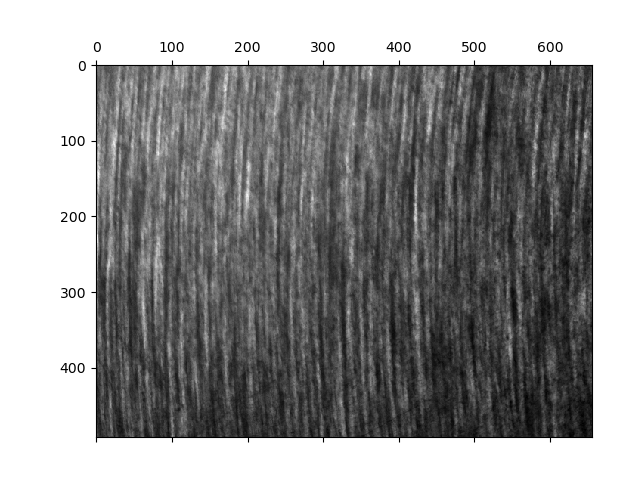

In [5]:
#Specify where the data is stored and the image data filename. Must be in tiff format
data_dir = "Y:\\Dennis Terwilliger\\Data\\2021-06-08\\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x\\"
sub_dir = "02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_1\\"
data_file = "02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_1_MMStack_Default.ome.tif"

#Image read using tiff_file module
im = skimage.io.imread(data_dir+sub_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

In [7]:
#Here, we rescale the image. We downscale the image by a factor of 3
# in the time dimension, downscale by factor of 2 in x, and downscale
# by a factor of 2 in y
new_im = downscale_local_mean(im, (3,2,2))
print("Original image dimensions: ", im.shape)
print("Downscaled image dimensions: ", new_im.shape)

Original image dimensions:  (2000, 492, 656)
Downscaled image dimensions:  (667, 246, 328)


#### Finding the median image (for background subtraction)

In [9]:
#Calculate the median of the image. This will allow us to subtract off
#  inhomogeneous illumination
im_median = np.median(new_im,axis=0)

#We further blur that median filter
im_median_blur = skimage.filters.gaussian(im_median, 19)

<IPython.core.display.Javascript object>


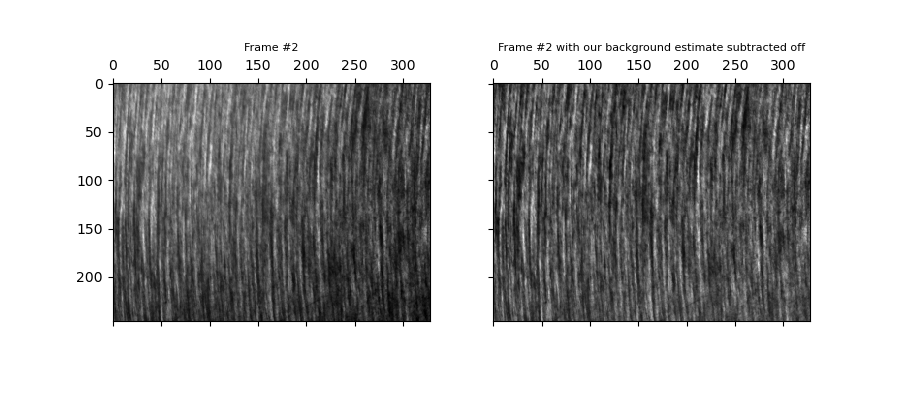

Text(0.5, 1.0, 'Frame #2 with our background estimate subtracted off')

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,4))
ax1.matshow(new_im[1], cmap=matplotlib.cm.gray)
ax1.set_title("Frame #2", fontsize=8)
ax2.matshow(new_im[1]-im_median_blur, cmap=matplotlib.cm.gray)
ax2.set_title("Frame #2 with our background estimate subtracted off", fontsize=8)

#### Generating a binary image

We'll try a couple different thersholding methods to give us a binary image. 

You can read more on these [image filtering techniques here](https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding.html). 

Determined a threshold value of 844


<IPython.core.display.Javascript object>


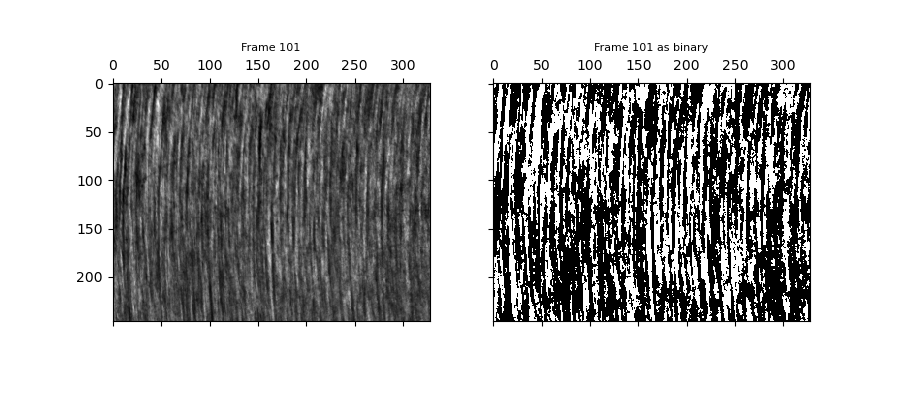

Text(0.5, 1.0, 'Frame 101 as binary')

In [21]:
frame_number = 100
threshold_value = threshold_otsu(new_im[frame_number]-im_median_blur)
print("Determined a threshold value of %i" % threshold_value)
binary_image = new_im[frame_number]-im_median_blur > threshold_value

#Display the original and binary image
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,4))
ax1.matshow(new_im[frame_number]-im_median_blur, cmap=matplotlib.cm.gray)
ax1.set_title("Frame %i" % (frame_number+1), fontsize=8)
ax2.matshow(binary_image, cmap=matplotlib.cm.gray)
ax2.set_title("Frame %i as binary" % (frame_number+1), fontsize=8)

<IPython.core.display.Javascript object>


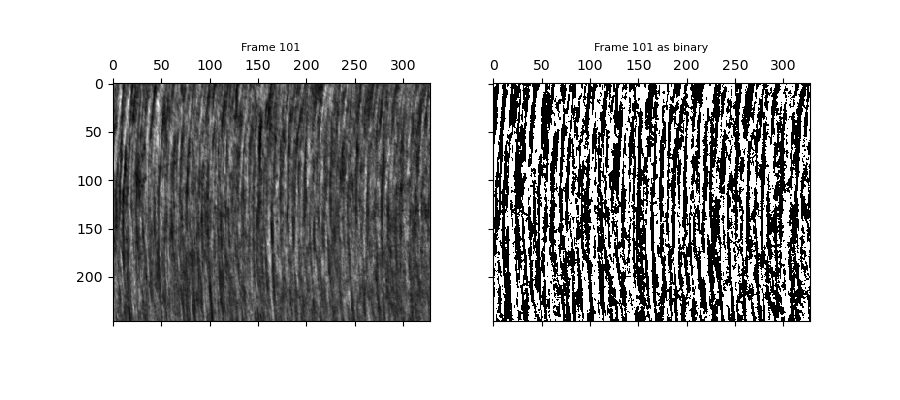

Text(0.5, 1.0, 'Frame 101 as binary')

In [23]:
#Here, we try a new thresholding method. This method does *not* find a threshold
# value that is the same for the whole image. Instead, we find threshold values
# for different parts of the image (the size of these parts determined by the
# 'blocksize' parameter)

frame_number = 100
block_size = 51
local_thresh = threshold_local(new_im[frame_number]-im_median_blur, block_size, offset=10)
binary_image = new_im[frame_number]-im_median_blur > local_thresh


#Display the original and binary image
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,4))
ax1.matshow(new_im[frame_number]-im_median_blur, cmap=matplotlib.cm.gray)
ax1.set_title("Frame %i" % (frame_number+1), fontsize=8)
ax2.matshow(binary_image, cmap=matplotlib.cm.gray)
ax2.set_title("Frame %i as binary" % (frame_number+1), fontsize=8)

<IPython.core.display.Javascript object>


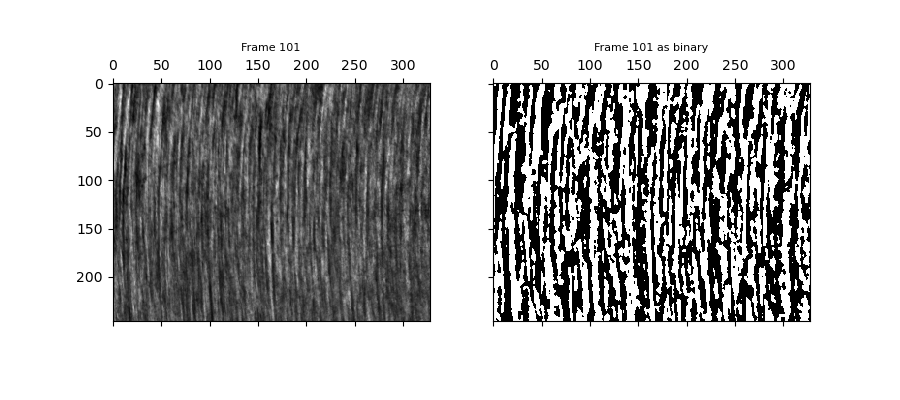

Text(0.5, 1.0, 'Frame 101 as binary')

In [28]:
#Next, we apply the local thresholding not to the image with the background subtracted
#  but to the image minus background with a Gaussian filter applied. 

frame_number = 100
filtered_image = skimage.filters.gaussian(new_im[frame_number]-im_median_blur, 1)
block_size = 51
local_thresh = threshold_local(filtered_image, block_size, offset=0.01)
binary_image = filtered_image > local_thresh


#Display the original and binary image
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,4))
ax1.matshow(new_im[frame_number]-im_median_blur, cmap=matplotlib.cm.gray)
ax1.set_title("Frame %i" % (frame_number+1), fontsize=8)
ax2.matshow(binary_image, cmap=matplotlib.cm.gray)
ax2.set_title("Frame %i as binary" % (frame_number+1), fontsize=8)

In [32]:
def run_length(iterable):
    '''
    Finds the lengths of runs of zeros.
    '''
    zero_runs = []
    for val, thing in groupby(iterable):
        if val==0:
            zero_runs.append(len(list(thing)))
    return zero_runs

In [33]:
def process_image(im, downscale=(3,2,2), median_blur_size=19):
    '''
    This function filters and processes the raw image data. 
    We first downscale the image. The default is to downscale the 
      three dimensions by 3,2,2. 
    Next, a median is calculated and filtered with a Gaussian filter
      with blur size given by parameter 'median_blur_size'.
    We then return the original image stack with the background
      subtracted off.
    
    '''
    new_im = downscale_local_mean(im, downscale)
    im_median = np.median(new_im,axis=0)
    im_median_blur = skimage.filters.gaussian(im_median, median_blur_size)
    return new_im-im_median_blur

def run_length_all_images(ims, block_size=35, offset_for_threshold=10, gaussian_filter_size = None,
                         save_images_for_debugging = False, dataset_title=' ', dir_to_save=None):
    '''
    Goes through all images in a stack and finds the run lengths.
    
    '''
    num_frames,vertical_pixels,horizontal_pixels = ims.shape
    all_runs_vertical = []
    all_runs_horizontal = []
    for i in range(num_frames):
        if gaussian_filter_size is not None:
            new_im = skimage.filters.gaussian(ims[i], gaussian_filter_size)
        else:
            new_im = ims[i]
        local_thresh = threshold_local(new_im, block_size, offset=offset_for_threshold)
        binary_image = new_im > local_thresh
        if save_images_for_debugging and i==0:
            fig, axs = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)
            fig.suptitle(dataset_title)
            axs[0].matshow(new_im, cmap='gray')
            axs[0].set_title("image")
            axs[1].matshow(binary_image, cmap='gray')
            axs[1].set_title("binary image")
            if dir_to_save is not None:
                plt.savefig(dir_to_save + "debug_%s_image.png" % dataset_title, dpi=300)
            plt.close()
        for j in range(horizontal_pixels):
            all_runs_vertical.append(run_length(binary_image[:,j]))
        for k in range(vertical_pixels):
            all_runs_horizontal.append(run_length(binary_image[k,:]))
    return (list(chain(*all_runs_vertical)), list(chain(*all_runs_horizontal)))

<IPython.core.display.Javascript object>


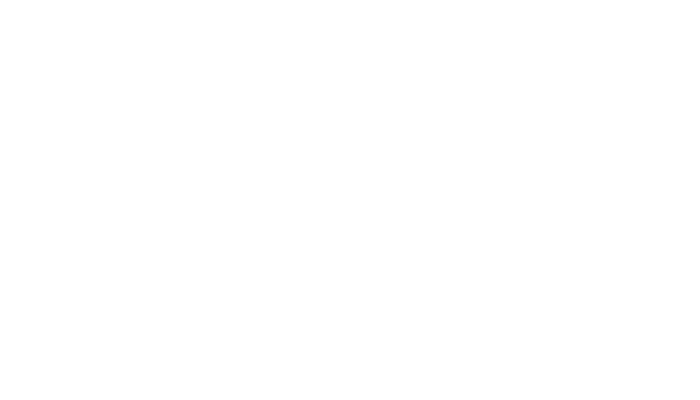

In [34]:
av,ah = run_length_all_images(process_image(im)[::20], block_size=31, offset_for_threshold=0.01, gaussian_filter_size=1,
                             save_images_for_debugging=True)

In [35]:
bins = np.linspace(1,328,80)

<IPython.core.display.Javascript object>


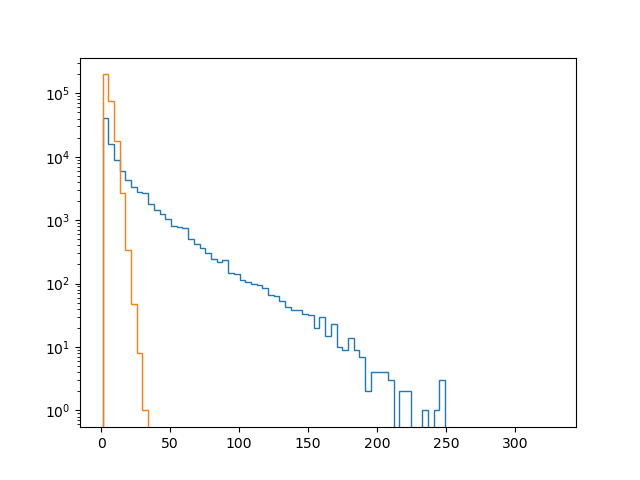

In [36]:
plt.figure()
n_vert,bins,_ = plt.hist(av, bins=bins, log=True, histtype='step')
n_hor,bins,_ = plt.hist(ah, bins=bins, log=True, histtype='step')

In [37]:
print("Mean run length in horizontal direction is %i." % np.mean(ah))
print("Mean run length in vertical direction is %i." % np.mean(av))
print("Median run length in horizontal direction is %i." % np.median(ah))
print("Median run length in vertical direction is %i." % np.median(av))

Mean run length in horizontal direction is 4.
Mean run length in vertical direction is 15.
Median run length in horizontal direction is 4.
Median run length in vertical direction is 7.


In [38]:
print("Number of runs >200 in horizontal direction is %i." % np.sum(np.array(ah)>200))
print("Number of runs >200 in vertical direction is %i." % np.sum(np.array(av)>200))

Number of runs >200 in horizontal direction is 0.
Number of runs >200 in vertical direction is 19.
